LOADING CREDIT CARD FRAUD DATASET
Dataset loaded successfully!
Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Fraud cases: 492 out of 284807 (0.17%)
Created 'Amount_log' feature using log1p transformation

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Time        284807 non-null  float64 
 1   V1          284807 non-null  float64 
 2   V2          284807 non-null  float64 
 3   V3          284807 non-null  float64 
 4   V4          284807 non-null  float64 
 5   V5          284807 non-null  float64 
 6   V6          284807 non-null  float64 
 7   V7          284807 non-null  float64 
 8   V8          284807 non-null  float64 

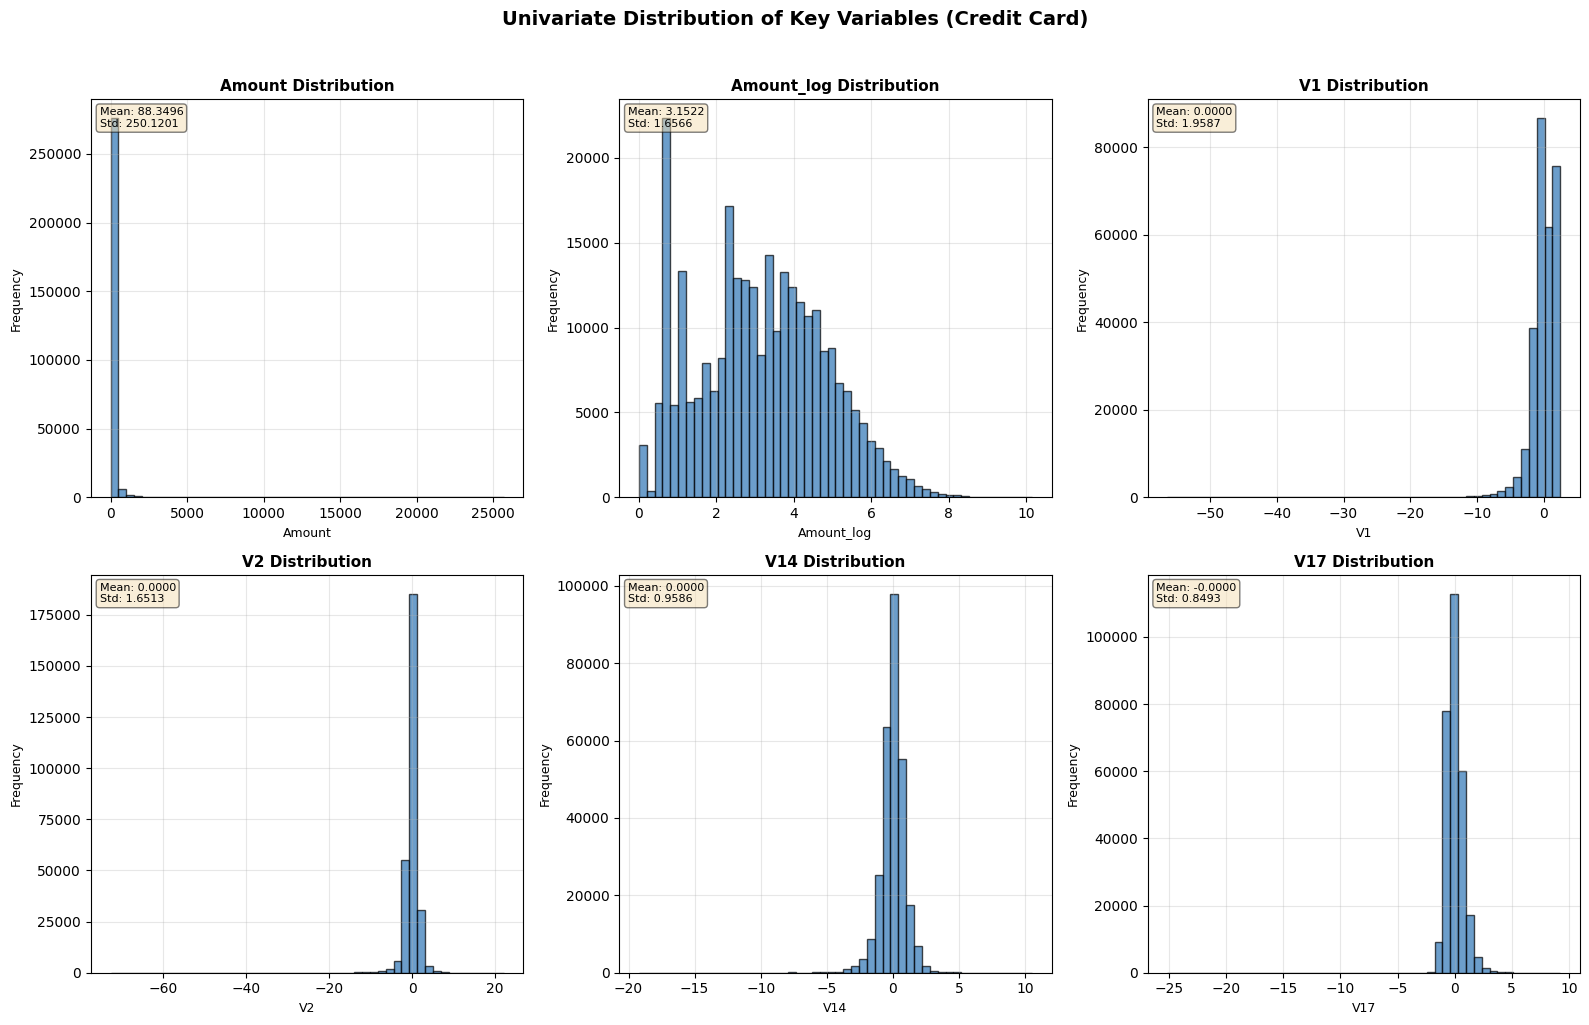


BIVARIATE ANALYSIS: FRAUD VS NON-FRAUD - CREDIT CARD


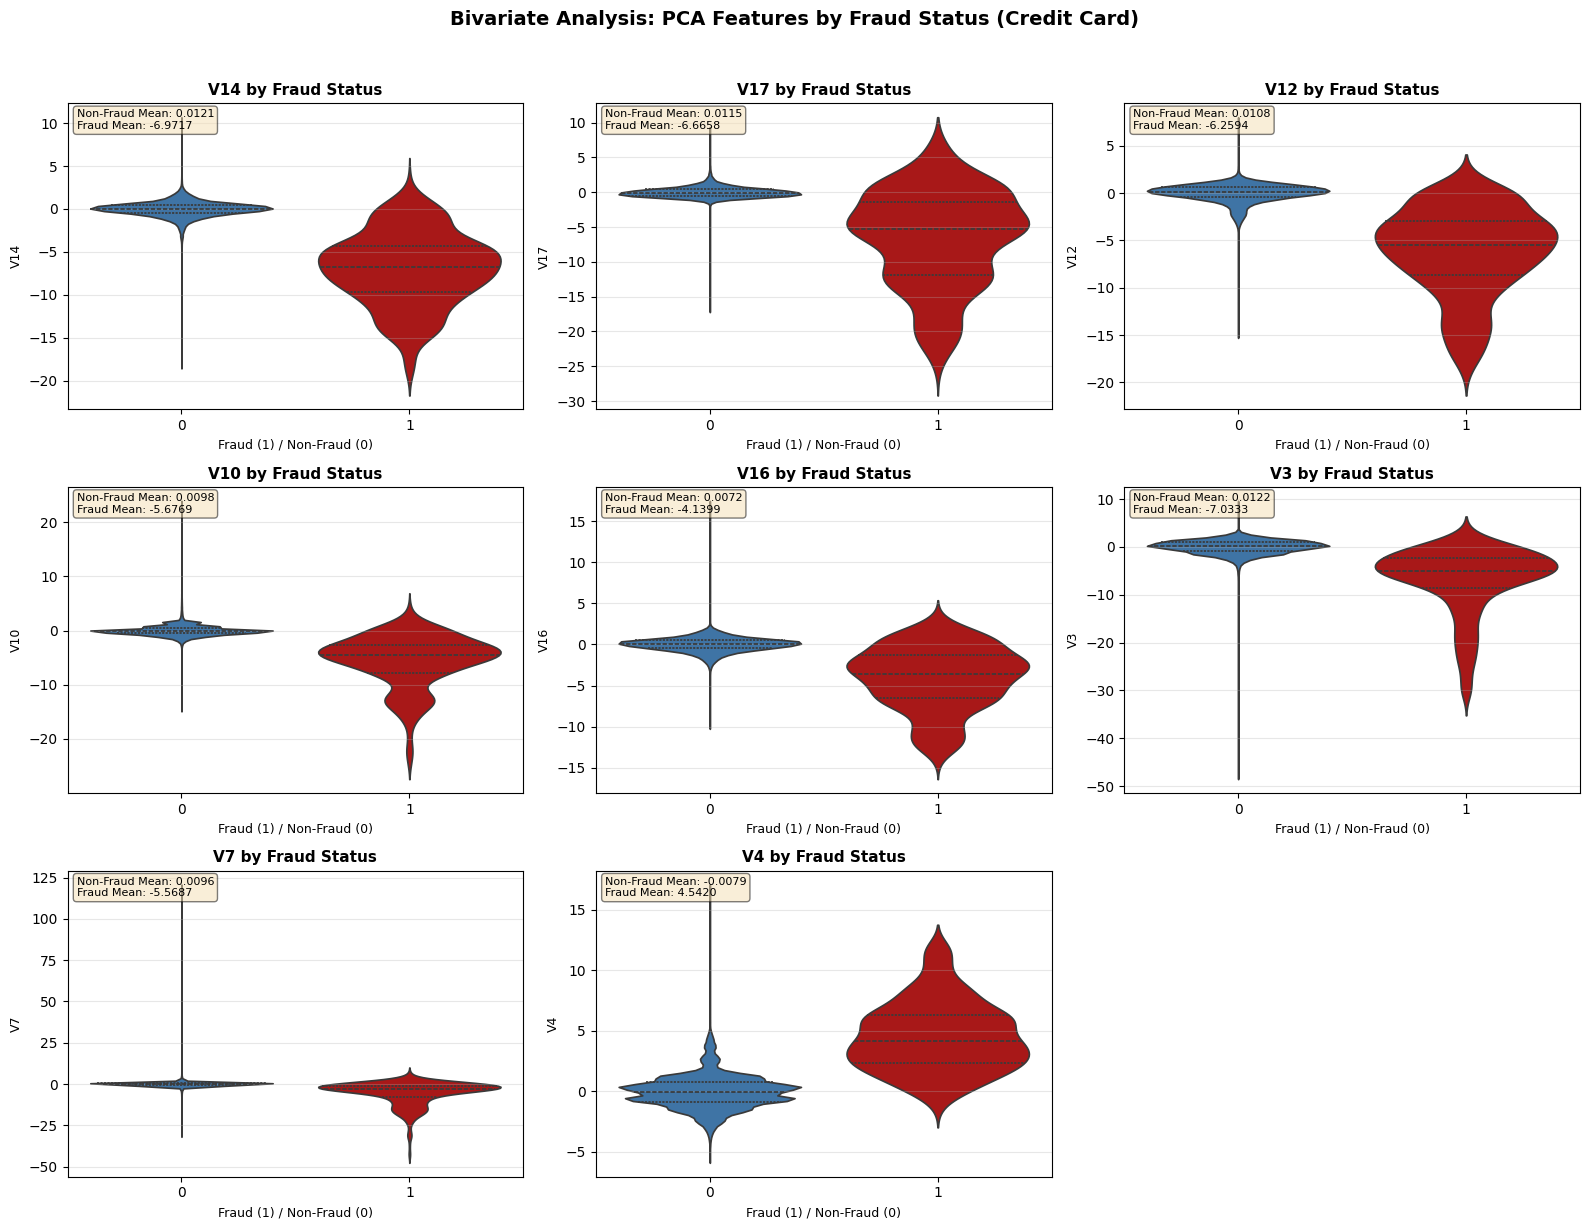


DISTRIBUTION COMPARISON: FRAUD VS NON-FRAUD


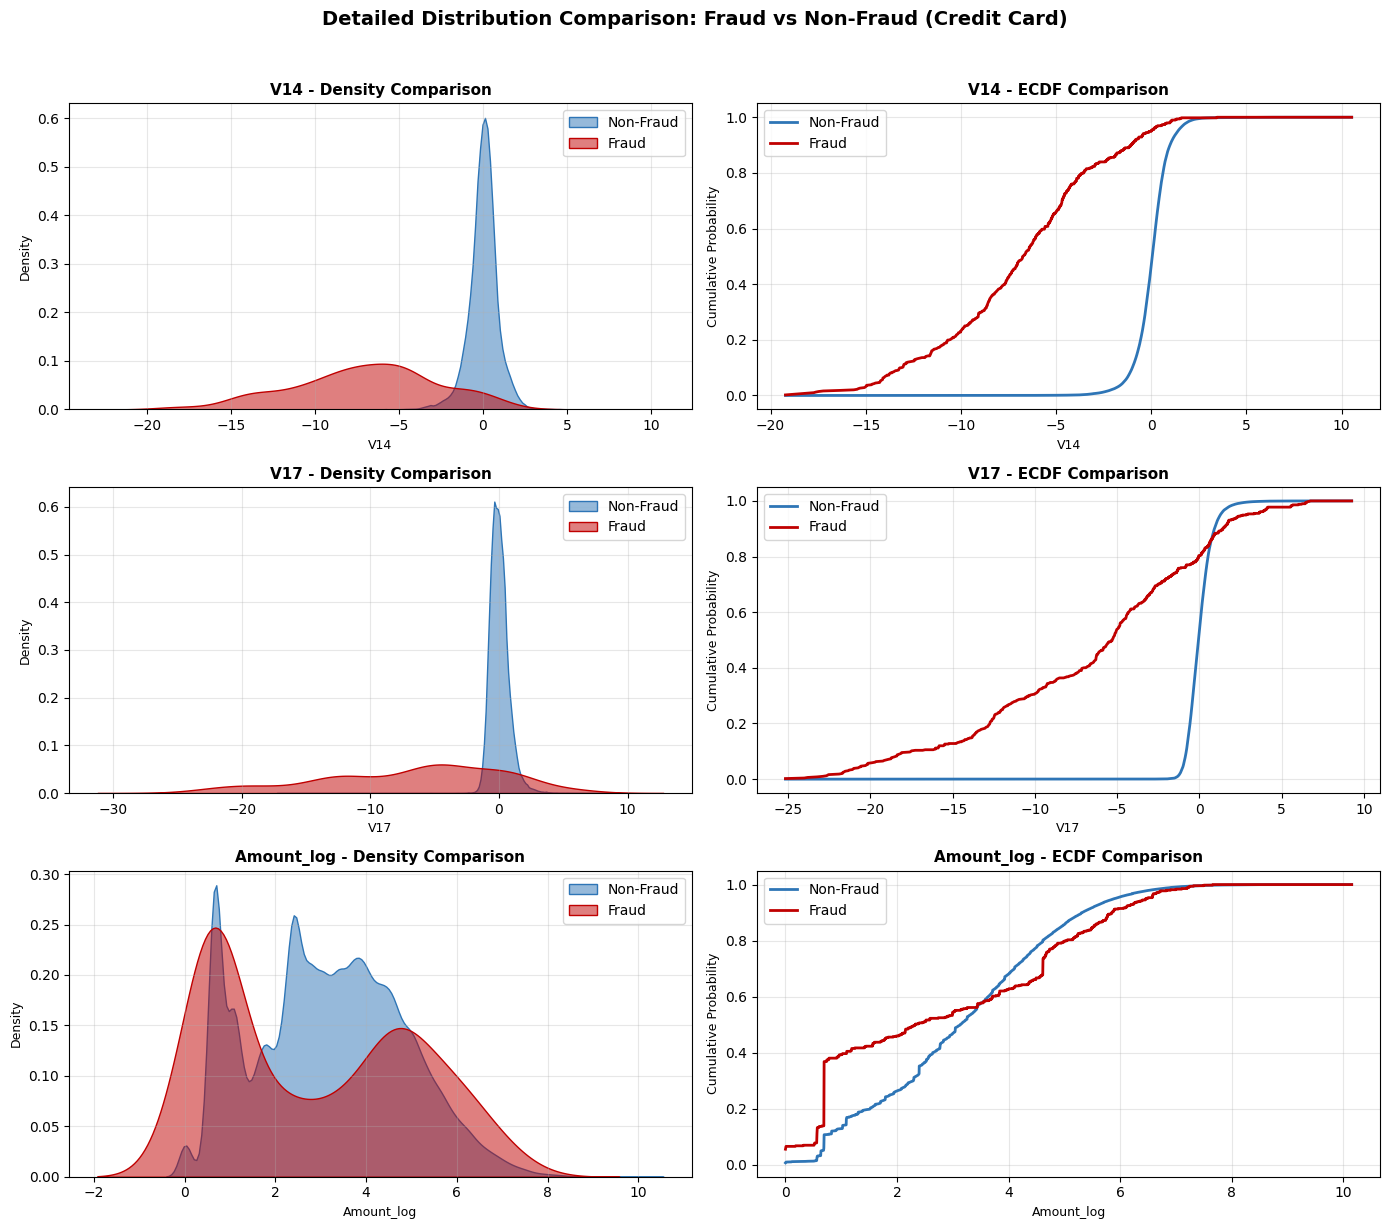


STATISTICAL SIGNIFICANCE TESTING
Testing statistical significance for 31 features...

Statistical Significance Test Results (31 features tested):
----------------------------------------------------------------------------------------------------
Top 10 Most Significant Features (by Mann-Whitney p-value):
Feature  Fraud_Mean  Non_Fraud_Mean  Mean_Difference    MW_p_value    TT_p_value  Cohens_d  Significant_MW  Significant_TT
    V14   -6.971723        0.012064        -6.983787 1.471581e-260 1.040151e-140 -2.259076            True            True
     V4    4.542029       -0.007860         4.549889 3.625904e-248 4.587317e-136  2.013335            True            True
    V12   -6.259393        0.010832        -6.270225 8.416027e-247 1.481317e-112 -1.866983            True            True
    V11    3.800173       -0.006576         3.806749 4.910592e-226 4.577212e-120  1.882183            True            True
    V10   -5.676883        0.009824        -5.686707 9.611131e-222  3.382884e

In [6]:
# ===== IMPORT REQUIRED LIBRARIES =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings('ignore')

# ===== LOAD CREDIT CARD DATA =====
print("="*60)
print("LOADING CREDIT CARD FRAUD DATASET")
print("="*60)

# Load your dataset - UPDATE THIS PATH/FILENAME
# Example: if using the popular creditcard.csv dataset
try:
    # Option 1: If you have a CSV file
    cc_data = pd.read_csv('../data/raw/creditcard.csv')
    
    # Option 2: If using a different format, adjust accordingly
    # cc_data = pd.read_excel('creditcard.xlsx')
    # cc_data = pd.read_parquet('creditcard.parquet')
    
    print(f"Dataset loaded successfully!")
    print(f"Shape: {cc_data.shape}")
    print(f"Columns: {list(cc_data.columns)}")
    print(f"Fraud cases: {cc_data['Class'].sum()} out of {len(cc_data)} ({cc_data['Class'].sum()/len(cc_data)*100:.2f}%)")
    
    # Create cc_features DataFrame (all features including 'Class')
    cc_features = cc_data.copy()
    
    # Convert 'Class' to categorical for better plotting
    cc_features['Class'] = cc_features['Class'].astype('category')
    
    # Check if Amount_log exists, if not create it
    if 'Amount' in cc_features.columns and 'Amount_log' not in cc_features.columns:
        # Apply log transformation to handle skewness (add small constant to avoid log(0))
        cc_features['Amount_log'] = np.log1p(cc_features['Amount'])
        print("Created 'Amount_log' feature using log1p transformation")
    
    # Display basic info
    print("\nDataset Info:")
    print(cc_features.info())
    print("\nMissing values:")
    print(cc_features.isnull().sum())
    
except FileNotFoundError:
    print("ERROR: Dataset file not found!")
    print("Please ensure 'creditcard.csv' exists in the current directory")
    print("OR update the file path in the code")
    # Create empty DataFrame to prevent further errors
    cc_features = pd.DataFrame()
except KeyError as e:
    print(f"ERROR: Required column not found: {e}")
    print("Please ensure your dataset has 'Class' column for fraud detection")
    cc_features = pd.DataFrame()
except Exception as e:
    print(f"ERROR loading dataset: {e}")
    cc_features = pd.DataFrame()

# Only proceed with analysis if data is loaded successfully
if not cc_features.empty and 'Class' in cc_features.columns:
    # ===== UNIVARIATE DISTRIBUTION PLOTS =====
    print("\n" + "="*60)
    print("UNIVARIATE DISTRIBUTION ANALYSIS - CREDIT CARD")
    print("="*60)

    # Create univariate plots for key variables
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    # Plot key features - using only columns that exist
    features_to_plot = ['Amount', 'Amount_log', 'V1', 'V2', 'V14', 'V17']
    available_features = [f for f in features_to_plot if f in cc_features.columns]
    
    # Adjust subplot layout based on available features
    if len(available_features) > 0:
        if len(available_features) < 6:
            # Adjust figure size if fewer features
            fig, axes = plt.subplots(1, len(available_features), figsize=(4*len(available_features), 6))
            if len(available_features) == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
        
        for idx, feature in enumerate(available_features):
            # Plot distribution
            axes[idx].hist(cc_features[feature].dropna(), bins=50, alpha=0.7,
                          color='#2E75B6', edgecolor='black')
            axes[idx].set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
            axes[idx].set_xlabel(feature, fontsize=9)
            axes[idx].set_ylabel('Frequency', fontsize=9)
            axes[idx].grid(True, alpha=0.3)
            
            # Add statistics
            stats_text = f'Mean: {cc_features[feature].mean():.4f}\nStd: {cc_features[feature].std():.4f}'
            axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                          fontsize=8, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.suptitle('Univariate Distribution of Key Variables (Credit Card)', 
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('../results/univariate_distributions_creditcard.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("WARNING: None of the specified features found in the dataset")

    # ===== BIVARIATE TARGET-VS-FEATURE ANALYSIS =====
    print("\n" + "="*60)
    print("BIVARIATE ANALYSIS: FRAUD VS NON-FRAUD - CREDIT CARD")
    print("="*60)

    # Select top PCA features for analysis - using only available columns
    top_pca_features = ['V14', 'V17', 'V12', 'V10', 'V16', 'V3', 'V7', 'V4']
    available_pca_features = [f for f in top_pca_features if f in cc_features.columns]
    
    if available_pca_features:
        # Create subplots
        n_features = len(available_pca_features)
        n_rows = (n_features + 2) // 3  # Calculate rows needed (3 columns per row)
        
        fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4*n_rows))
        axes = axes.flatten()
        
        for idx in range(len(axes)):
            if idx < n_features:
                feature = available_pca_features[idx]
                # Create violin plot - FIX: Use string keys for palette
                # Convert Class values to strings for plotting
                plot_data = cc_features.copy()
                plot_data['Class_str'] = plot_data['Class'].astype(str)
                
                sns.violinplot(x='Class_str', y=feature, data=plot_data, ax=axes[idx],
                              palette={'0': '#2E75B6', '1': '#C00000'}, inner='quartile')
                
                axes[idx].set_title(f'{feature} by Fraud Status', fontsize=11, fontweight='bold')
                axes[idx].set_xlabel('Fraud (1) / Non-Fraud (0)', fontsize=9)
                axes[idx].set_ylabel(feature, fontsize=9)
                axes[idx].grid(True, alpha=0.3, axis='y')
                
                # Calculate and display statistics
                fraud_mean = cc_features[cc_features['Class'] == 1][feature].mean()
                non_fraud_mean = cc_features[cc_features['Class'] == 0][feature].mean()
                
                stats_text = f'Non-Fraud Mean: {non_fraud_mean:.4f}\nFraud Mean: {fraud_mean:.4f}'
                axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                              fontsize=8, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            else:
                # Hide unused subplots
                axes[idx].set_visible(False)

        plt.suptitle('Bivariate Analysis: PCA Features by Fraud Status (Credit Card)',
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('../results/bivariate_analysis_creditcard.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("WARNING: No PCA features found for bivariate analysis")

    # ===== DISTRIBUTION COMPARISON FOR KEY FEATURES =====
    print("\n" + "="*60)
    print("DISTRIBUTION COMPARISON: FRAUD VS NON-FRAUD")
    print("="*60)

    # Select key features for detailed comparison
    key_features = ['V14', 'V17', 'Amount_log']
    available_key_features = [f for f in key_features if f in cc_features.columns]
    
    if available_key_features:
        fig, axes = plt.subplots(len(available_key_features), 2, figsize=(14, 4*len(available_key_features)))
        
        # Handle case when only one feature
        if len(available_key_features) == 1:
            axes = axes.reshape(1, -1)
        
        for idx, feature in enumerate(available_key_features):
            # Left: Density plot comparison
            # Convert Class to numeric for filtering
            sns.kdeplot(data=cc_features[cc_features['Class'] == 0][feature], 
                       ax=axes[idx, 0], label='Non-Fraud', color='#2E75B6', fill=True, alpha=0.5)
            sns.kdeplot(data=cc_features[cc_features['Class'] == 1][feature], 
                       ax=axes[idx, 0], label='Fraud', color='#C00000', fill=True, alpha=0.5)
            axes[idx, 0].set_title(f'{feature} - Density Comparison', fontsize=11, fontweight='bold')
            axes[idx, 0].set_xlabel(feature, fontsize=9)
            axes[idx, 0].set_ylabel('Density', fontsize=9)
            axes[idx, 0].legend()
            axes[idx, 0].grid(True, alpha=0.3)
            
            # Right: ECDF plot
            # Calculate ECDF for both classes
            # Convert Class to numeric for filtering
            ecdf_non_fraud = ECDF(cc_features[cc_features['Class'] == 0][feature])
            ecdf_fraud = ECDF(cc_features[cc_features['Class'] == 1][feature])
            
            x_sorted = np.sort(np.concatenate([
                cc_features[cc_features['Class'] == 0][feature],
                cc_features[cc_features['Class'] == 1][feature]
            ]))
            
            axes[idx, 1].plot(x_sorted, ecdf_non_fraud(x_sorted), 
                             color='#2E75B6', label='Non-Fraud', linewidth=2)
            axes[idx, 1].plot(x_sorted, ecdf_fraud(x_sorted), 
                             color='#C00000', label='Fraud', linewidth=2)
            axes[idx, 1].set_title(f'{feature} - ECDF Comparison', fontsize=11, fontweight='bold')
            axes[idx, 1].set_xlabel(feature, fontsize=9)
            axes[idx, 1].set_ylabel('Cumulative Probability', fontsize=9)
            axes[idx, 1].legend()
            axes[idx, 1].grid(True, alpha=0.3)

        plt.suptitle('Detailed Distribution Comparison: Fraud vs Non-Fraud (Credit Card)',
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('../results/distribution_comparison_creditcard.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("WARNING: No key features found for distribution comparison")

    # ===== STATISTICAL SIGNIFICANCE TESTING =====
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*60)

    # Create significance test results table
    significance_results = []
    
    # Get numeric columns (excluding 'Class' for now)
    numeric_columns = cc_features.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove 'Class' from features to test
    features_to_test = [col for col in numeric_columns if col != 'Class']
    
    print(f"Testing statistical significance for {len(features_to_test)} features...")
    
    for feature in features_to_test:
        # Convert Class to numeric for filtering
        fraud_data = cc_features[cc_features['Class'] == 1][feature].dropna()
        non_fraud_data = cc_features[cc_features['Class'] == 0][feature].dropna()
        
        if len(fraud_data) > 1 and len(non_fraud_data) > 1:
            try:
                # Mann-Whitney U test (non-parametric)
                stat_mw, p_mw = mannwhitneyu(fraud_data, non_fraud_data, alternative='two-sided')
                
                # T-test (parametric)
                stat_tt, p_tt = ttest_ind(fraud_data, non_fraud_data, equal_var=False)
                
                # Calculate effect size (Cohen's d)
                mean_diff = fraud_data.mean() - non_fraud_data.mean()
                pooled_std = np.sqrt((fraud_data.std()**2 + non_fraud_data.std()**2) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
                
                significance_results.append({
                    'Feature': feature,
                    'Fraud_Mean': fraud_data.mean(),
                    'Non_Fraud_Mean': non_fraud_data.mean(),
                    'Mean_Difference': mean_diff,
                    'MW_p_value': p_mw,
                    'TT_p_value': p_tt,
                    'Cohens_d': cohens_d,
                    'Significant_MW': p_mw < 0.05,
                    'Significant_TT': p_tt < 0.05
                })
            except Exception as e:
                print(f"  Skipping {feature}: {e}")
                continue

    # Convert to DataFrame and sort by significance
    if significance_results:
        significance_df = pd.DataFrame(significance_results)
        significance_df = significance_df.sort_values('MW_p_value')
        
        print(f"\nStatistical Significance Test Results ({len(significance_df)} features tested):")
        print("-" * 100)
        print(f"Top 10 Most Significant Features (by Mann-Whitney p-value):")
        print(significance_df.head(10).to_string(index=False))
        
        # Count significant features
        sig_count_mw = (significance_df['MW_p_value'] < 0.05).sum()
        sig_count_tt = (significance_df['TT_p_value'] < 0.05).sum()
        print(f"\nSignificant features (p < 0.05):")
        print(f"  - Mann-Whitney U test: {sig_count_mw} out of {len(significance_df)}")
        print(f"  - T-test: {sig_count_tt} out of {len(significance_df)}")
        
        # Save results to CSV
        significance_df.to_csv('../results/statistical_significance_creditcard.csv', index=False)
        print(f"\nFull results saved to: ../results/statistical_significance_creditcard.csv")
    else:
        print("WARNING: No features could be tested for statistical significance")

else:
    print("\n" + "="*60)
    print("ANALYSIS CANNOT BE COMPLETED")
    print("="*60)
    print("Reason: Dataset not loaded or missing 'Class' column")
    print("Please check:")
    print("1. The dataset file exists in the specified location")
    print("2. The dataset contains a 'Class' column (0=non-fraud, 1=fraud)")
    print("3. The dataset contains features (V1, V2, etc.)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)